In [1]:
%matplotlib inline

In [2]:
# pip install "qiskit>=1.0" "qiskit-aer>=0.15"

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit import transpile

# ----- Data layout (row-major) -----
# d0 d1 d2
# d3 d4 d5
# d6 d7 d8
n_data = 9

# Interior stabilizers (weight-4)
X_interior = [
    [0, 1, 3, 4],   # X0 (top-left face)
    [4, 5, 7, 8],   # X1 (bottom-right face)
]
Z_interior = [
    [3, 4, 6, 7],   # Z0 (bottom-left face)
    [1, 2, 4, 5],   # Z1 (top-right face)
]

# Border stabilizers (weight-2), chosen to commute with the above
X_border = [
    [1, 2],         # X_top
    [6, 7],         # X_bottom
]
Z_border = [
    [0, 3],         # Z_left
    [5, 8],         # Z_right
]

X_checks = X_interior + X_border   # total 4 X checks
Z_checks = Z_interior + Z_border   # total 4 Z checks

# ----- Registers -----
q_data = QuantumRegister(n_data, "d")
q_ax   = QuantumRegister(len(X_checks), "ax")  # 4 X-ancillas
q_az   = QuantumRegister(len(Z_checks), "az")  # 4 Z-ancillas
c_x    = ClassicalRegister(len(X_checks), "mx")
c_z    = ClassicalRegister(len(Z_checks), "mz")
qc = QuantumCircuit(q_data, q_ax, q_az, c_x, c_z, name="d3_surface_code_round_borders")

# ----- ONE ROUND OF SYNDROME EXTRACTION -----
# X stabilizer measurement:
#  H on ancilla, CNOT(ancilla->data) for each data in check, H, measure
for a_idx, ds in enumerate(X_checks):
    anc = q_ax[a_idx]
    qc.reset(anc)
    qc.h(anc)
    for qd in ds:
        qc.cx(anc, q_data[qd])
    qc.h(anc)
    qc.measure(anc, c_x[a_idx])

# Z stabilizer measurement:
#  reset ancilla |0>, CNOT(data->ancilla) for each data in check, measure
for a_idx, ds in enumerate(Z_checks):
    anc = q_az[a_idx]
    qc.reset(anc)
    for qd in ds:
        qc.cx(q_data[qd], anc)
    qc.measure(anc, c_z[a_idx])

# print(qc)


In [3]:

# ----- Run on Aer simulator -----
backend = AerSimulator()
tqc = transpile(qc, backend)
res = backend.run(tqc, shots=1000).result()
counts = res.get_counts(tqc)

print("\nSyndrome (mx[0..3] mz[0..3]) counts:")
for k, v in sorted(counts.items(), key=lambda kv: -kv[1]):
    print(k, v)


Syndrome (mx[0..3] mz[0..3]) counts:
0000 0000 77
0000 0001 68
0000 1100 65
0000 0100 64
0000 0011 64
0000 1001 63
0000 0111 63
0000 0010 63
0000 1101 61
0000 0110 61
0000 1000 60
0000 1010 60
0000 1111 59
0000 1110 59
0000 1011 58
0000 0101 55


In [4]:

# ----- Helper: quick commutation sanity check (X vs Z overlaps must be even) -----
def commute_ok(x_checks, z_checks):
    bad = []
    for i, xs in enumerate(x_checks):
        xs_set = set(xs)
        for j, zs in enumerate(z_checks):
            if (len(xs_set.intersection(zs)) % 2) == 1:
                bad.append((i, j, xs, zs))
    return bad

violations = commute_ok(X_checks, Z_checks)
assert len(violations) == 0, f"Found noncommuting pairs: {violations}"

# ----- Try an error injection to see border syndromes fire -----
def run_with_error(q_err=None, err_gate="X"):
    qc_err = QuantumCircuit(q_data, q_ax, q_az, c_x, c_z)
    # Inject error on a chosen data qubit before checks
    if q_err is not None:
        if err_gate.upper() == "X":
            qc_err.x(q_data[q_err])
        elif err_gate.upper() == "Z":
            qc_err.z(q_data[q_err])
        elif err_gate.upper() == "Y":
            qc_err.y(q_data[q_err])

    # X checks
    for a_idx, ds in enumerate(X_checks):
        anc = q_ax[a_idx]
        qc_err.reset(anc); qc_err.h(anc)
        for qd in ds:
            qc_err.cx(anc, q_data[qd])
        qc_err.h(anc); qc_err.measure(anc, c_x[a_idx])

    # Z checks
    for a_idx, ds in enumerate(Z_checks):
        anc = q_az[a_idx]
        qc_err.reset(anc)
        for qd in ds:
            qc_err.cx(q_data[qd], anc)
        qc_err.measure(anc, c_z[a_idx])

    tqc_err = transpile(qc_err, backend)
    res_err = backend.run(tqc_err, shots=2000).result()
    return res_err.get_counts(tqc_err)

In [5]:
# pip install qiskit qiskit-aer
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error, ReadoutError
from qiskit import transpile

def run_with_errors(
    qc,
    p1=1e-3,            # 1-qubit depolarizing error prob per 1q gate
    p2=2e-3,            # 2-qubit depolarizing error prob per 2q gate
    p_meas=5e-3,        # measurement bit-flip prob
    p_reset=5e-3,       # reset flips to wrong state with this prob
    shots=10000,
    seed=1234,
    basis_gates=("id","x","y","z","h","s","sdg","t","tdg","rx","ry","rz","cx"),
):
    """
    Runs an existing QuantumCircuit `qc` under a simple local noise model and returns counts.
    Does NOT modify `qc`.
    """
    # --- Build noise model ---
    noise = NoiseModel()

    # 1-qubit depolarizing on all 1q basis gates
    err1 = depolarizing_error(p1, 1)
    for g in ["id","x","y","z","h","s","sdg","t","tdg","rx","ry","rz"]:
        noise.add_all_qubit_quantum_error(err1, g)

    # 2-qubit depolarizing on CX
    err2 = depolarizing_error(p2, 2)
    noise.add_all_qubit_quantum_error(err2, "cx")

    # Measurement error: classical flip with prob p_meas
    meas_error = ReadoutError([[1 - p_meas, p_meas],
                               [p_meas, 1 - p_meas]])
    noise.add_all_qubit_readout_error(meas_error)

    # Reset error: wrong reset with prob p_reset (|0>↔|1>)
    reset_error = pauli_error([("I", 1 - p_reset), ("X", p_reset)])
    noise.add_all_qubit_quantum_error(reset_error, "reset")

    # --- Simulate with Aer ---
    backend = AerSimulator(noise_model=noise, seed_simulator=seed)
    tqc = transpile(qc, backend=backend, basis_gates=list(basis_gates), optimization_level=0)
    result = backend.run(tqc, shots=shots).result()
    counts = result.get_counts(tqc)
    return counts

# Example:
# counts = run_with_errors(qc, p1=1e-3, p2=2e-3, p_meas=5e-3, p_reset=5e-3, shots=20000)
# print(counts)


In [6]:
# Example:
counts = run_with_errors(qc, p1=1e-3, p2=2e-3, p_meas=5e-3, p_reset=5e-3, shots=20000)
print(counts)


/Users/eli/dev/superstabilizer_splicing/.venv/lib/python3.11/site-packages/qiskit/compiler/transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(


{'0101 0000': 1, '1010 0001': 1, '0101 1010': 1, '1010 0110': 1, '0101 1110': 1, '1010 1101': 1, '0101 0011': 1, '0110 1111': 1, '1010 1111': 2, '1100 0111': 1, '1001 0110': 4, '0101 0111': 4, '1001 1011': 1, '0101 0101': 2, '0110 0000': 2, '0011 0110': 3, '0101 0110': 1, '0011 1101': 5, '1001 0010': 2, '1001 0111': 2, '0110 1011': 1, '1001 0011': 1, '0110 0110': 2, '1100 1101': 2, '1000 1100': 15, '0101 0010': 3, '0100 1100': 19, '0110 0010': 3, '1010 1110': 3, '0011 1100': 6, '0110 1001': 4, '0011 1010': 4, '0101 0001': 2, '1001 1100': 5, '0110 0111': 2, '0010 1011': 19, '1010 0011': 3, '1001 1111': 2, '0100 1000': 18, '0100 0111': 14, '0100 1111': 18, '1001 1001': 2, '0001 1110': 19, '0001 0110': 10, '0001 1000': 15, '0011 0000': 4, '1010 0101': 1, '0011 1111': 4, '0011 0100': 5, '1100 0101': 1, '1100 1001': 2, '0010 1110': 29, '0011 1011': 4, '1011 1000': 1, '0011 1000': 5, '1001 0000': 1, '0010 1101': 12, '0001 1111': 19, '0000 0111': 1210, '0100 0101': 15, '0000 1000': 1184, '100

In [7]:

print("\nInject X error on edge qubit d1 (should flip nearby Z-type syndromes, including borders):")
counts_x = run_with_error(q_err=1, err_gate="X")
for k, v in sorted(counts_x.items(), key=lambda kv: -kv[1]):
    print(k, v)

print("\nInject Z error on edge qubit d6 (should flip nearby X-type syndromes, including borders):")
counts_z = run_with_error(q_err=6, err_gate="Z")
for k, v in sorted(counts_z.items(), key=lambda kv: -kv[1]):
    print(k, v)


Inject X error on edge qubit d1 (should flip nearby Z-type syndromes, including borders):
0010 0100 146
0010 1110 132
0010 1100 132
0010 0101 130
0010 1001 129
0010 0111 129
0010 0000 126
0010 1011 123
0010 1000 123
0010 0110 122
0010 0001 121
0010 1010 121
0010 1111 121
0010 1101 118
0010 0011 115
0010 0010 112

Inject Z error on edge qubit d6 (should flip nearby X-type syndromes, including borders):
0000 0000 142
0000 1111 141
0000 1110 136
0000 0110 133
0000 1100 132
0000 0010 131
0000 0101 130
0000 1000 127
0000 1011 125
0000 0100 124
0000 1101 123
0000 1001 116
0000 0111 116
0000 1010 114
0000 0011 109
0000 0001 101


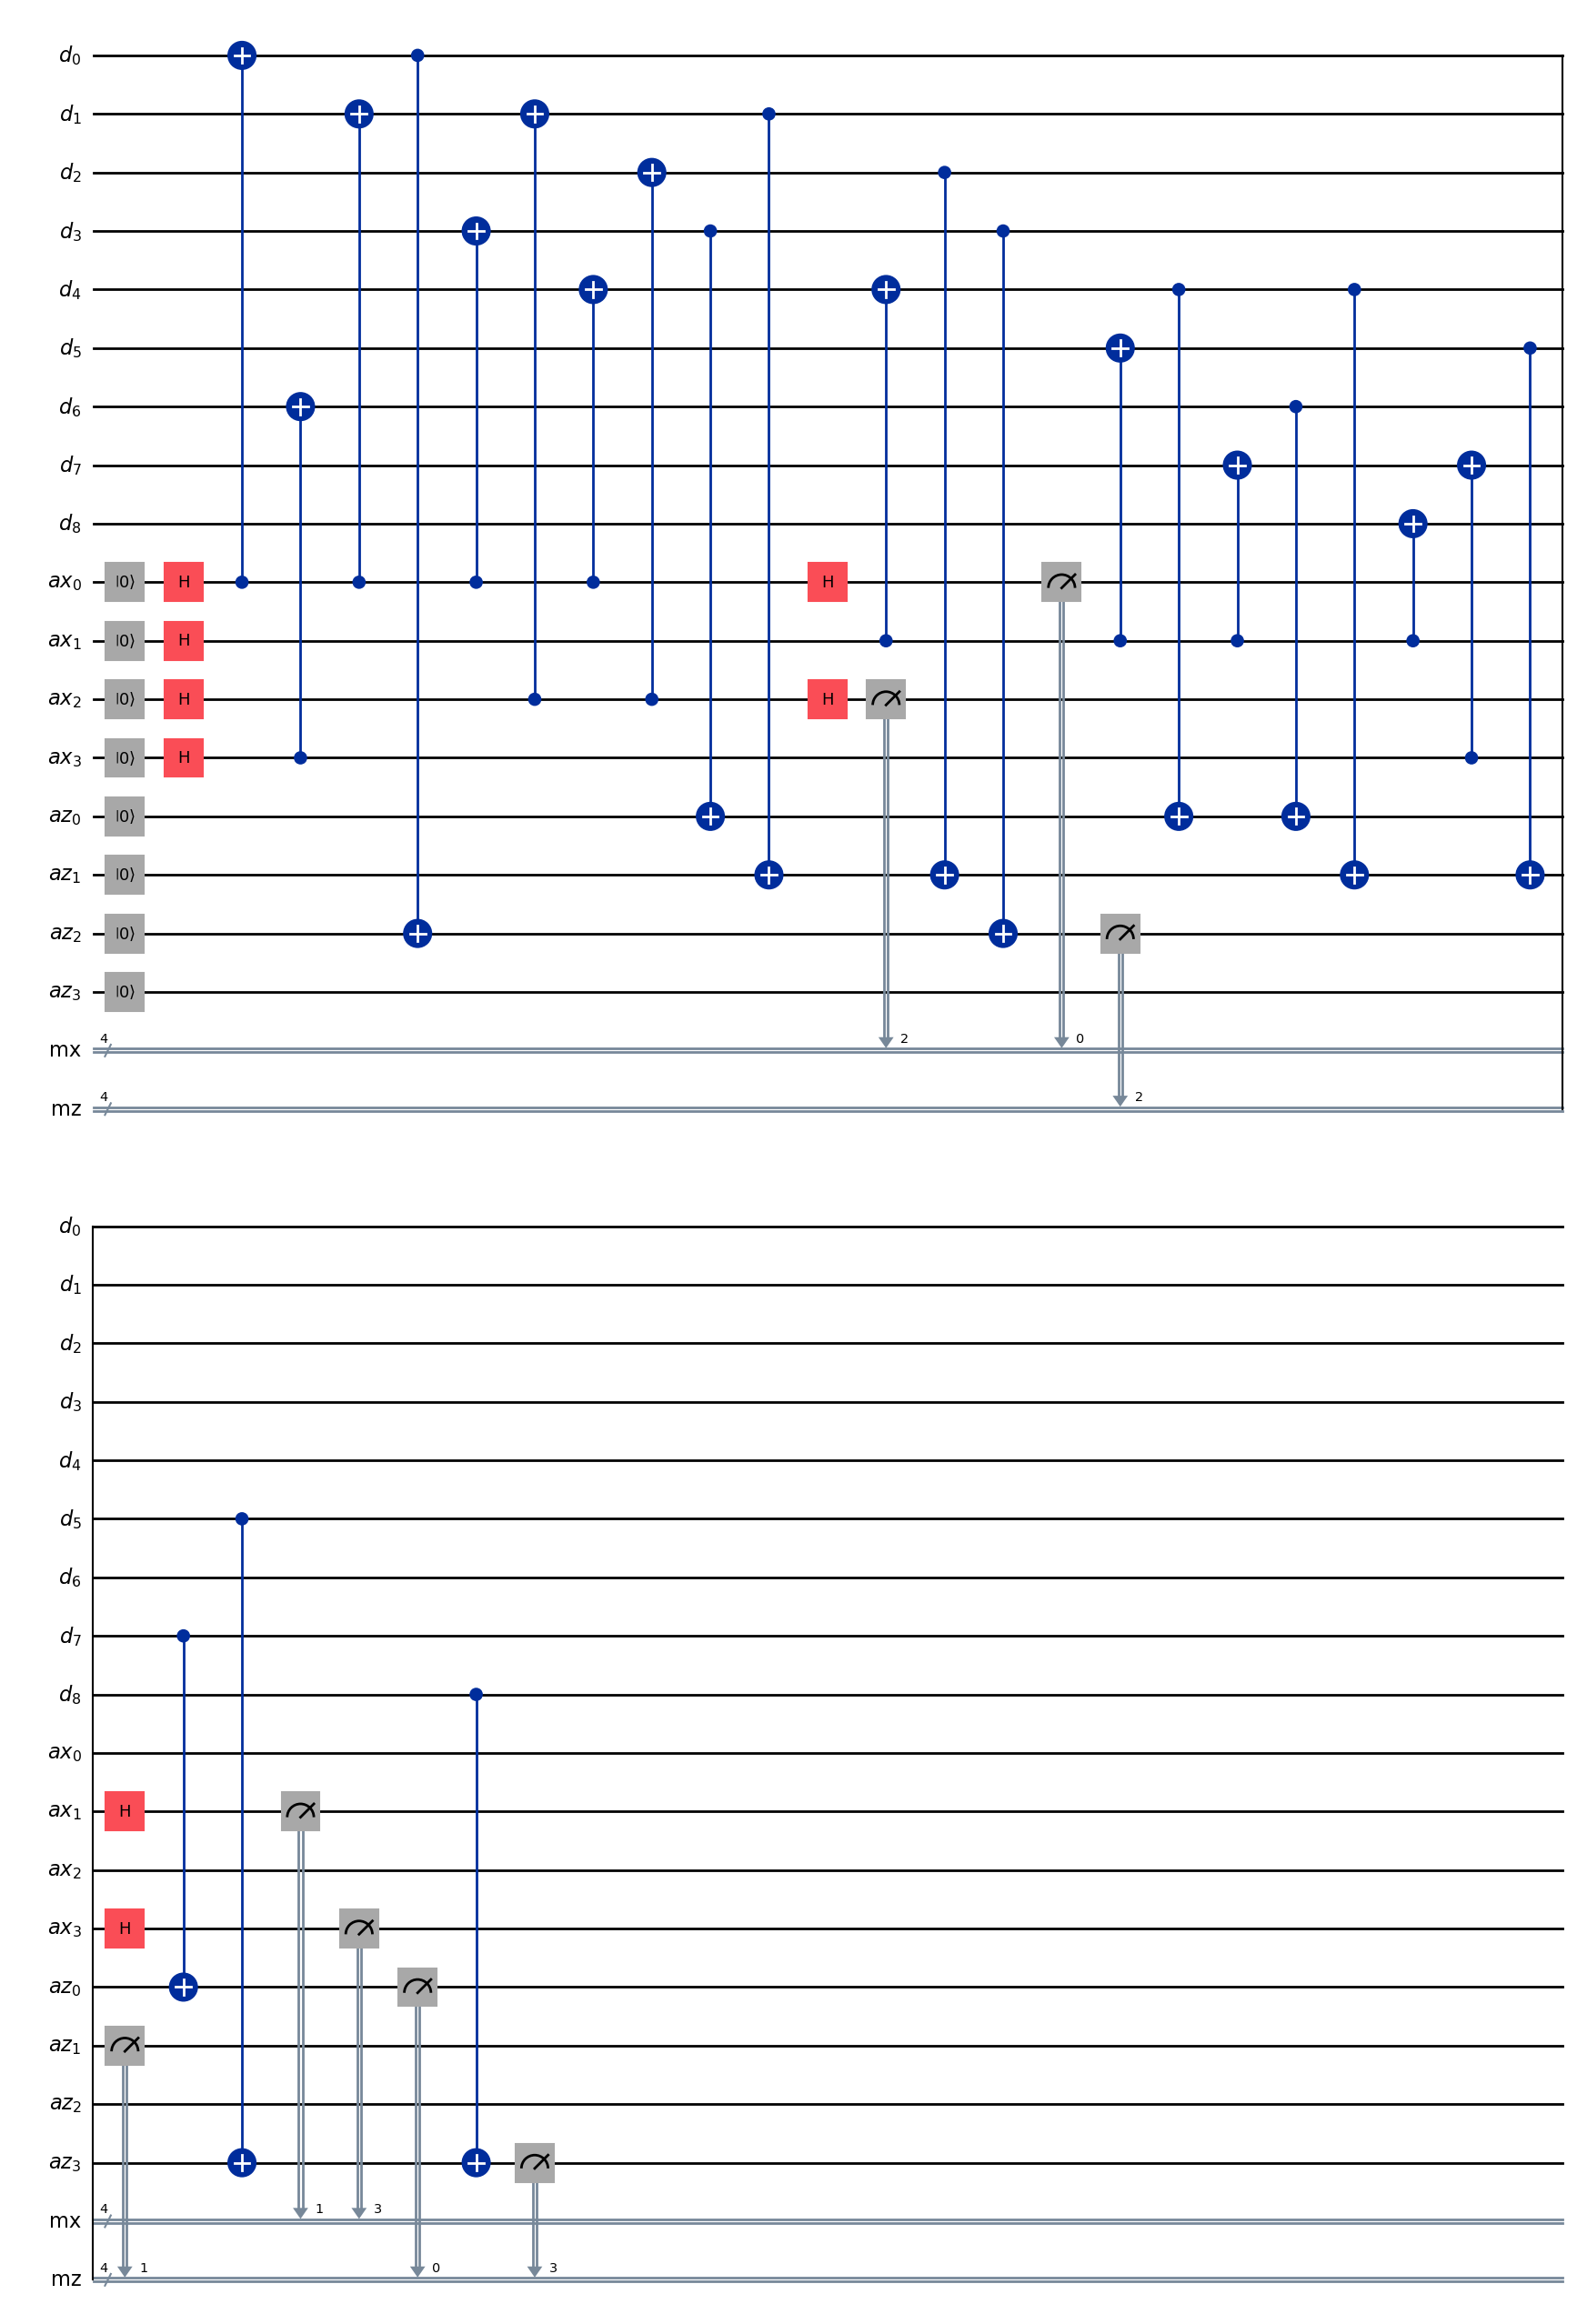

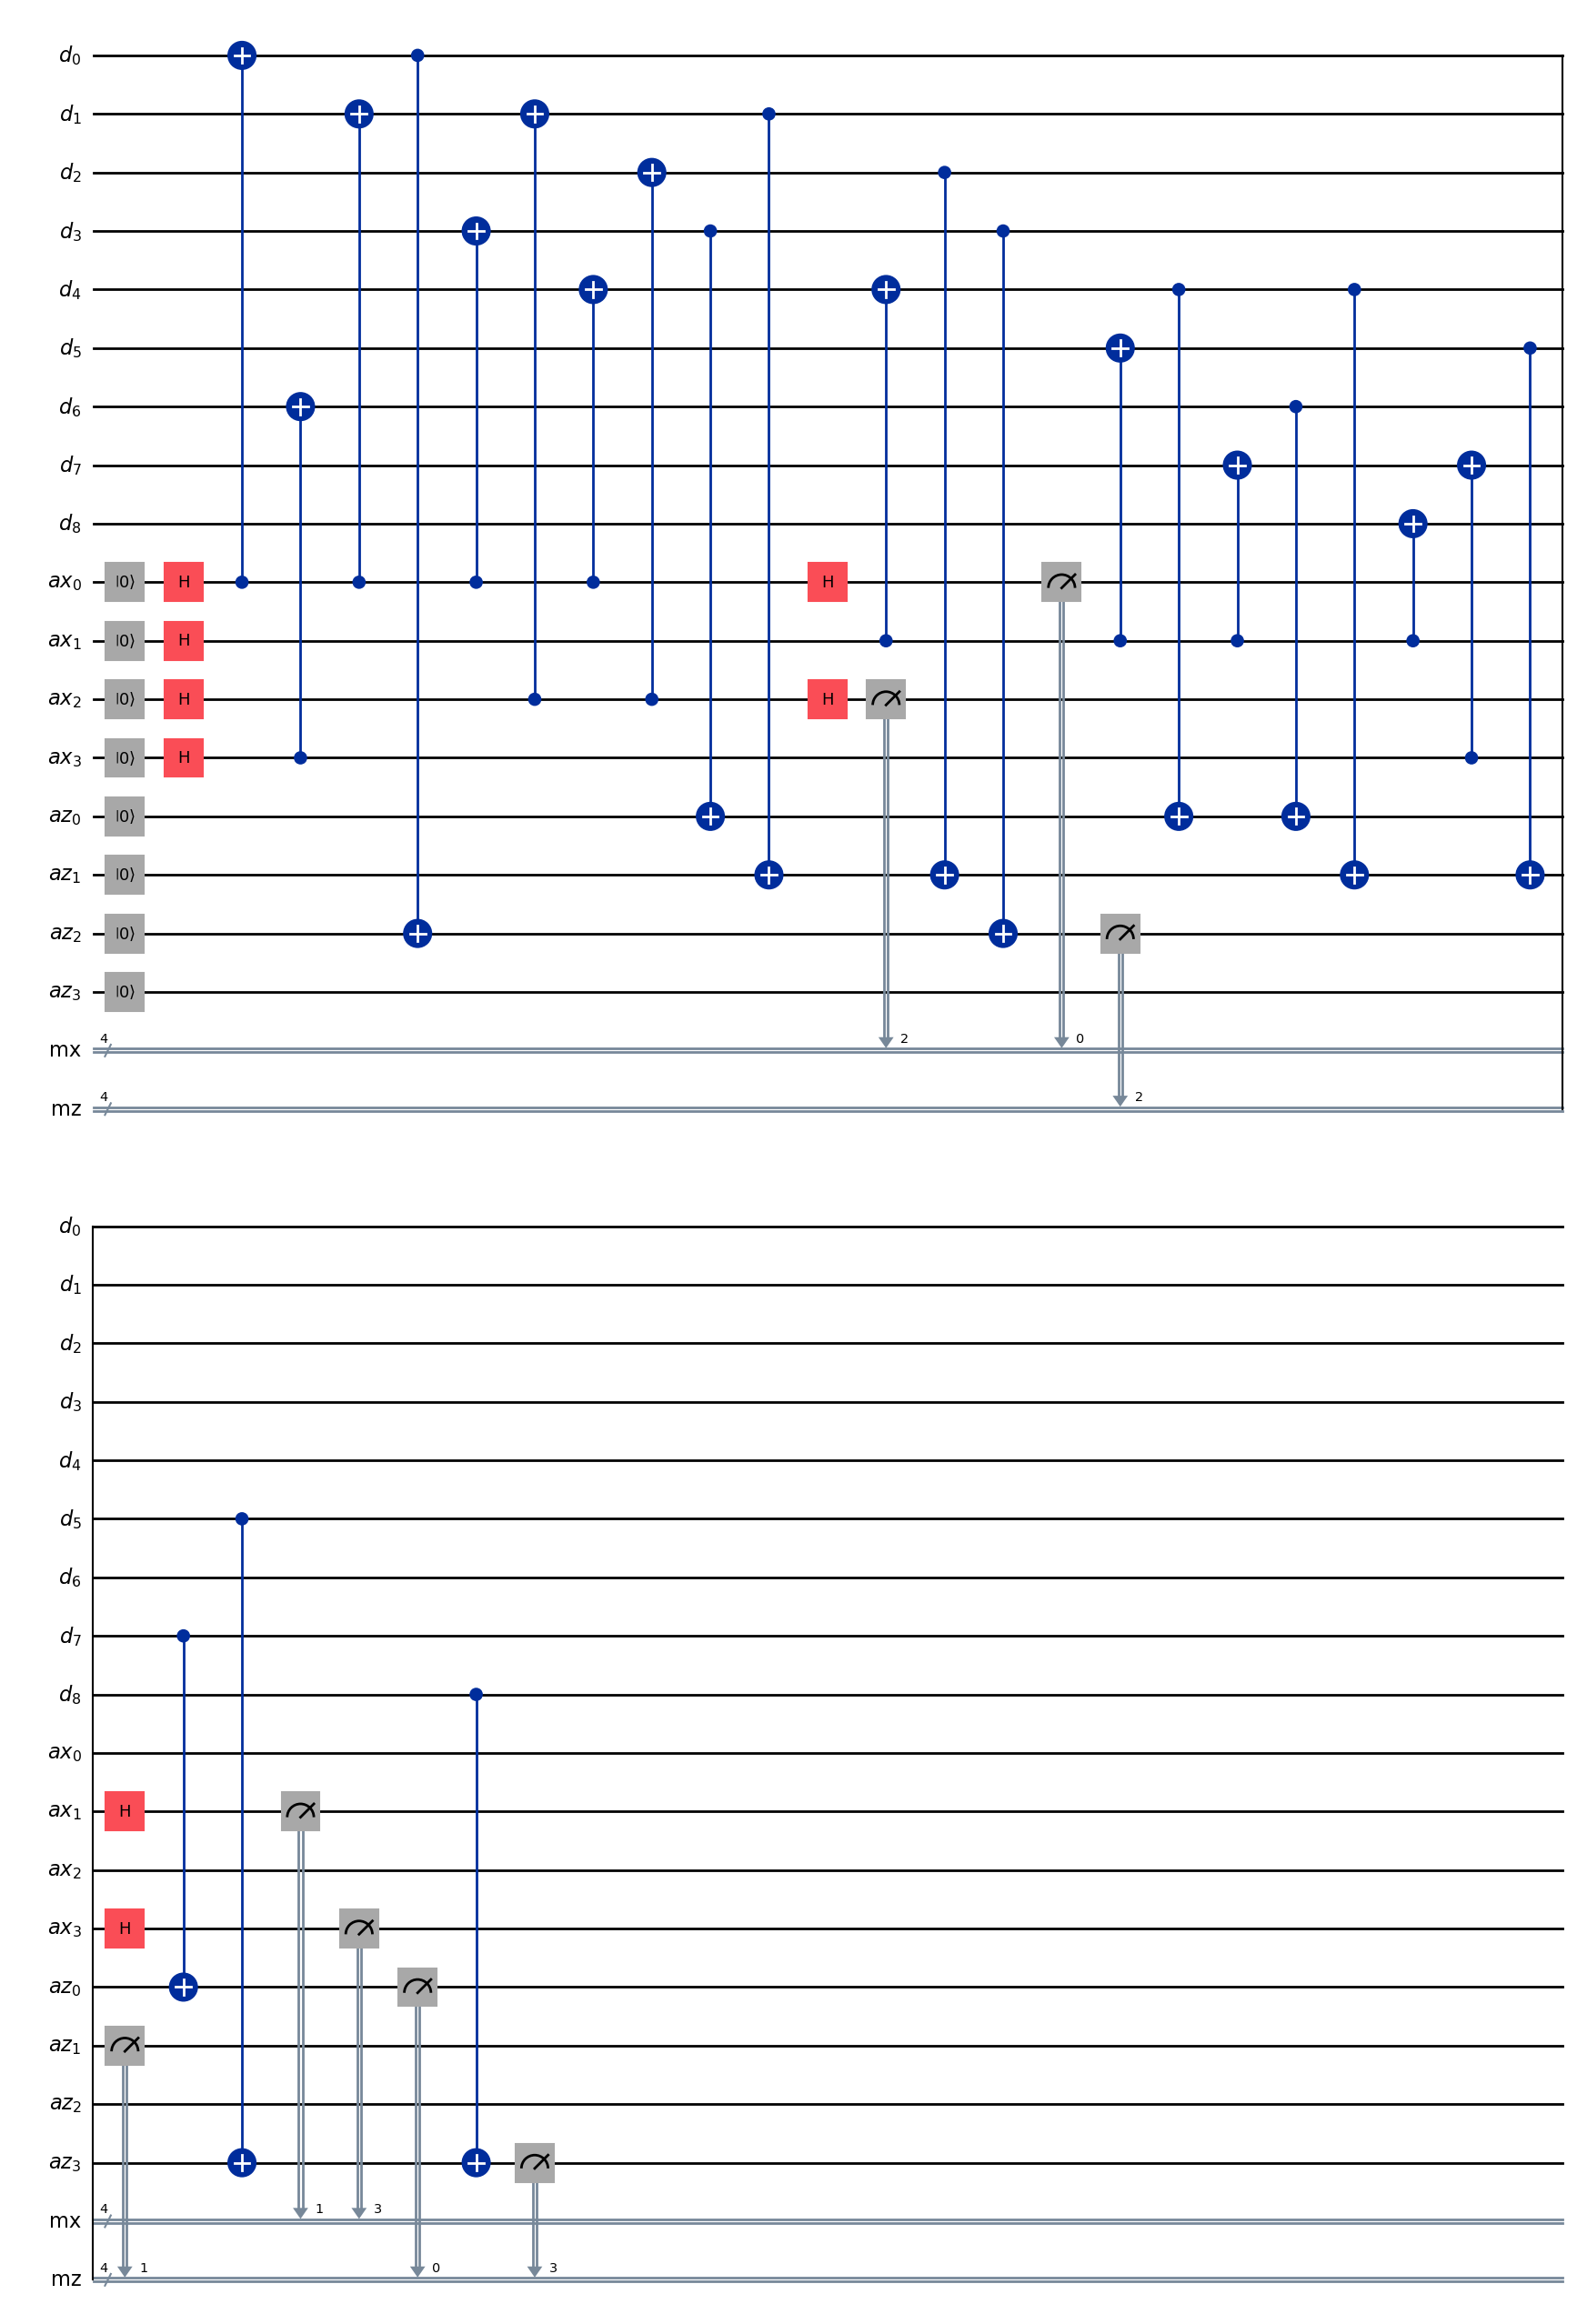

In [8]:
qc.draw(output="mpl")

In [9]:
# Matching / decoding cell
# Requires: pip install pymatching numpy

import numpy as np
from pymatching import Matching

def checks_to_H(checks, n_cols):
    """Convert list-of-lists checks into a binary parity matrix H."""
    H = np.zeros((len(checks), n_cols), dtype=np.uint8)
    for i, S in enumerate(checks):
        H[i, S] = 1
    return H

def init_pymatching_decoders(X_checks, Z_checks, n_data):
    """
    Build CSS decoders:
      - dec_Z uses H_X to decode Z errors from X-syndrome (mx)
      - dec_X uses H_Z to decode X errors from Z-syndrome (mz)
    Returns (dec_X, dec_Z, H_X, H_Z).
    """
    H_X = checks_to_H(X_checks, n_data)  # rows: X checks
    H_Z = checks_to_H(Z_checks, n_data)  # rows: Z checks
    dec_Z = Matching(H_X)                # decode Z errors from mx
    dec_X = Matching(H_Z)                # decode X errors from mz
    return dec_X, dec_Z, H_X, H_Z

def decode_x_errors(mz, dec_X):
    """
    Given Z-syndrome 'mz' (uint8 vector), estimate X-error support on data qubits.
    Returns np.ndarray of shape (n_data,) with 0/1 entries.
    """
    mz = np.asarray(mz, dtype=np.uint8).ravel()
    return dec_X.decode(mz)

def decode_z_errors(mx, dec_Z):
    """
    Given X-syndrome 'mx' (uint8 vector), estimate Z-error support on data qubits.
    Returns np.ndarray of shape (n_data,) with 0/1 entries.
    """
    mx = np.asarray(mx, dtype=np.uint8).ravel()
    return dec_Z.decode(mx)

# --- Initialize decoders (call once after your X_checks, Z_checks, n_data are defined) ---
dec_X, dec_Z, H_X, H_Z = init_pymatching_decoders(X_checks, Z_checks, n_data)


In [10]:

# --- Example usage (uncomment if you want a quick smoke test) ---
mx, mz = np.array([0,0,1,0], dtype=np.uint8), np.array([0,1,0,1], dtype=np.uint8)
x_hat = decode_x_errors(mz, dec_X)  # predicted X-error locations (from Z-syndrome)
z_hat = decode_z_errors(mx, dec_Z)  # predicted Z-error locations (from X-syndrome)
print("X-hat support:", np.where(x_hat)[0].tolist())
print("Z-hat support:", np.where(z_hat)[0].tolist())


X-hat support: [5]
Z-hat support: [2]


In [11]:

# --- One-shot surface-code error sampling + decoding + logical check ---

# Choose representative logical operators for our boundary choices:
#   - X-type boundaries are TOP/BOTTOM => logical X is any vertical X string
#   - Z-type boundaries are LEFT/RIGHT => logical Z is any horizontal Z string
X_L_support = np.array([1,4,7], dtype=int)  # vertical middle column
Z_L_support = np.array([3,4,5], dtype=int)  # horizontal middle row

def sample_pauli_errors(n, p=0.05, pX=None, pY=None, pZ=None, rng=None):
    """
    IID single-qubit Pauli channel on n data qubits.
    Default: each non-identity with equal prob p/3.
    Returns (x_err, z_err) as 0/1 vectors (Y = X and Z both 1).
    """
    if rng is None:
        rng = np.random.default_rng()
    if pX is None or pY is None or pZ is None:
        pX = pY = pZ = p / 3.0
    probs = np.array([1 - (pX + pY + pZ), pX, pY, pZ])
    # 0=I, 1=X, 2=Y, 3=Z
    choices = rng.choice(4, size=n, p=probs)
    x_err = ((choices == 1) | (choices == 2)).astype(np.uint8)
    z_err = ((choices == 3) | (choices == 2)).astype(np.uint8)
    return x_err, z_err, choices

def parity_on(indices, support):
    """Return parity of a 0/1 vector 'indices' over positions in 'support'."""
    return int(np.bitwise_xor.reduce(indices[support])) if len(support) else 0

def run_one_trial(p=0.05, rng=None, verbose=False):
    # 1) Sample physical Pauli errors (truth)
    x_err, z_err, choices = sample_pauli_errors(n_data, p=p, rng=rng)

    # 2) Compute ideal (perfect-measurement) syndromes
    #    X-syndrome comes from Z errors; Z-syndrome from X errors
    mx = (H_X @ z_err) % 2  # rows = X checks
    mz = (H_Z @ x_err) % 2  # rows = Z checks

    # 3) Decode
    x_hat = dec_X.decode(mz)  # estimate X-error pattern from Z-syndrome
    z_hat = dec_Z.decode(mx)  # estimate Z-error pattern from X-syndrome

    # 4) Residual after correction (what remains on data)
    rx = (x_err ^ x_hat).astype(np.uint8)  # residual X-type
    rz = (z_err ^ z_hat).astype(np.uint8)  # residual Z-type

    # 5) Check for logical errors:
    #    - residual X along Z_L (anticommutes with Z_L) -> logical Z flip
    #    - residual Z along X_L (anticommutes with X_L) -> logical X flip
    logical_Z = parity_on(rx, Z_L_support)
    logical_X = parity_on(rz, X_L_support)

    if verbose:
        def support_str(v): return "[" + ", ".join(map(str, np.where(v==1)[0])) + "]"
        pauli_map = {0:"I",1:"X",2:"Y",3:"Z"}
        truth_labels = [pauli_map[c] for c in choices]
        print("=== One-shot surface-code decode ===")
        print(f"Physical truth (per data qubit 0..8): {truth_labels}")
        print(f"X errors @ {support_str(x_err)}")
        print(f"Z errors @ {support_str(z_err)}")
        print(f"Syndrome mx (X checks): {mx.tolist()}")
        print(f"Syndrome mz (Z checks): {mz.tolist()}")
        print(f"Decoder X-hat @ {support_str(x_hat)}")
        print(f"Decoder Z-hat @ {support_str(z_hat)}")
        print(f"Residual X  @ {support_str(rx)}")
        print(f"Residual Z  @ {support_str(rz)}")
        print(f"Logical X error? {'YES' if logical_X else 'no'}")
        print(f"Logical Z error? {'YES' if logical_Z else 'no'}")

    # return dict(
    #     x_err=x_err, z_err=z_err, mx=mx, mz=mz,
    #     x_hat=x_hat, z_hat=z_hat, rx=rx, rz=rz,
    #     logical_X=logical_X, logical_Z=logical_Z
    # )
    return logical_X, logical_Z

# ---- Run a quick demo trial ----
# _ = run_one_trial(p=0.05, rng=np.random.default_rng(1234), verbose=True)
_ = run_one_trial(p=0.25, rng=None, verbose=True)


=== One-shot surface-code decode ===
Physical truth (per data qubit 0..8): ['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I']
X errors @ []
Z errors @ []
Syndrome mx (X checks): [0, 0, 0, 0]
Syndrome mz (Z checks): [0, 0, 0, 0]
Decoder X-hat @ []
Decoder Z-hat @ []
Residual X  @ []
Residual Z  @ []
Logical X error? no
Logical Z error? no


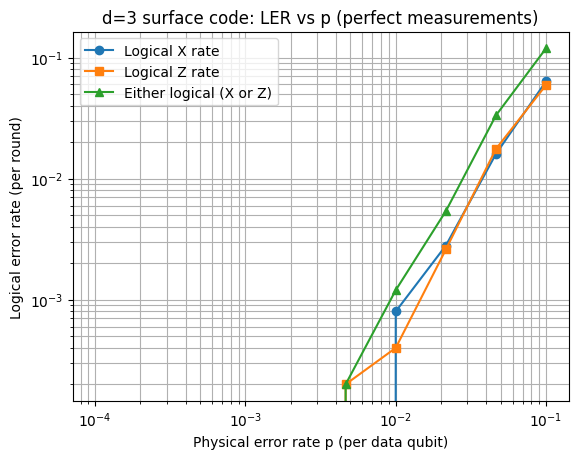

In [12]:
# --- Sweep configuration ---
ps = np.logspace(-4, -1, 10)      # 1e-4 ... 1e-1
trials_per_p = 5000               # bump to ~50k+ for smoother curves
rng = np.random.default_rng(1234)

LER_total = []
LER_X = []
LER_Z = []

for p in ps:
    lx = lz = 0
    for _ in range(trials_per_p):
        logical_X, logical_Z = run_one_trial(p, rng)
        lx += logical_X
        lz += logical_Z
    LER_X.append(lx / trials_per_p)
    LER_Z.append(lz / trials_per_p)
    LER_total.append((lx > 0 or lz > 0) / 1)  # not averaged yet

# LER_total as “either logical flip” rate:
LER_total = (np.array(LER_X) + np.array(LER_Z) - np.array(LER_X)*np.array(LER_Z)).tolist()

# --- Plot: LER vs p ---
import matplotlib.pyplot as plt
plt.figure()
plt.loglog(ps, LER_X, marker="o", label="Logical X rate")
plt.loglog(ps, LER_Z, marker="s", label="Logical Z rate")
plt.loglog(ps, LER_total, marker="^", label="Either logical (X or Z)")
plt.xlabel("Physical error rate p (per data qubit)")
plt.ylabel("Logical error rate (per round)")
plt.title("d=3 surface code: LER vs p (perfect measurements)")
plt.legend()
plt.grid(True, which="both")
plt.show()